# **New PatchTST 1**

## **Model Training**

In [ ]:
# !pip install -q transformers accelerate scikit-learn pandas matplotlib

import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    PatchTSTConfig,
    PatchTSTForPrediction,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Add this NEW CELL after imports, before data loading

import torch.nn.functional as F

class VariancePreservingLoss(torch.nn.Module):
    """
    Custom loss that combines prediction accuracy with variance preservation.
    """
    def __init__(self, alpha=0.1, beta=0.1):
        super().__init__()
        self.alpha = alpha  # Weight for MAE loss
        self.beta = beta    # Weight for variance penalty

    def forward(self, predictions, targets):
        # predictions: (batch, horizon, features)
        # targets: (batch, horizon, features)

        # 1. Main prediction loss (MAE)
        mae_loss = F.l1_loss(predictions, targets)

        # 2. Variance preservation loss
        # Calculate variance along time dimension for each feature
        pred_var = torch.var(predictions, dim=1)  # (batch, features)
        target_var = torch.var(targets, dim=1)    # (batch, features)

        # Penalize when predicted variance is lower than target variance
        variance_loss = F.mse_loss(pred_var, target_var)

        # 3. Total loss
        total_loss = self.alpha * mae_loss + self.beta * variance_loss

        return total_loss

# Initialize the custom loss
custom_loss_fn = VariancePreservingLoss(alpha=1.0, beta=0.3)

In [ ]:
# Paths
csv_path = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/1-RAW_HOURLY_DATA/minutely_sensor_dataset.csv"
df = pd.read_csv(csv_path)

# Identify feature columns: replace this line to match your exact column names
feature_cols = df.columns[:6].tolist()
assert len(feature_cols) == 6, f"Expected 6 features, got {len(feature_cols)}"

data = df[feature_cols].values.astype(np.float32)  # shape: (70000, 8)



STEP 1: RAW DATA VISUALIZATION


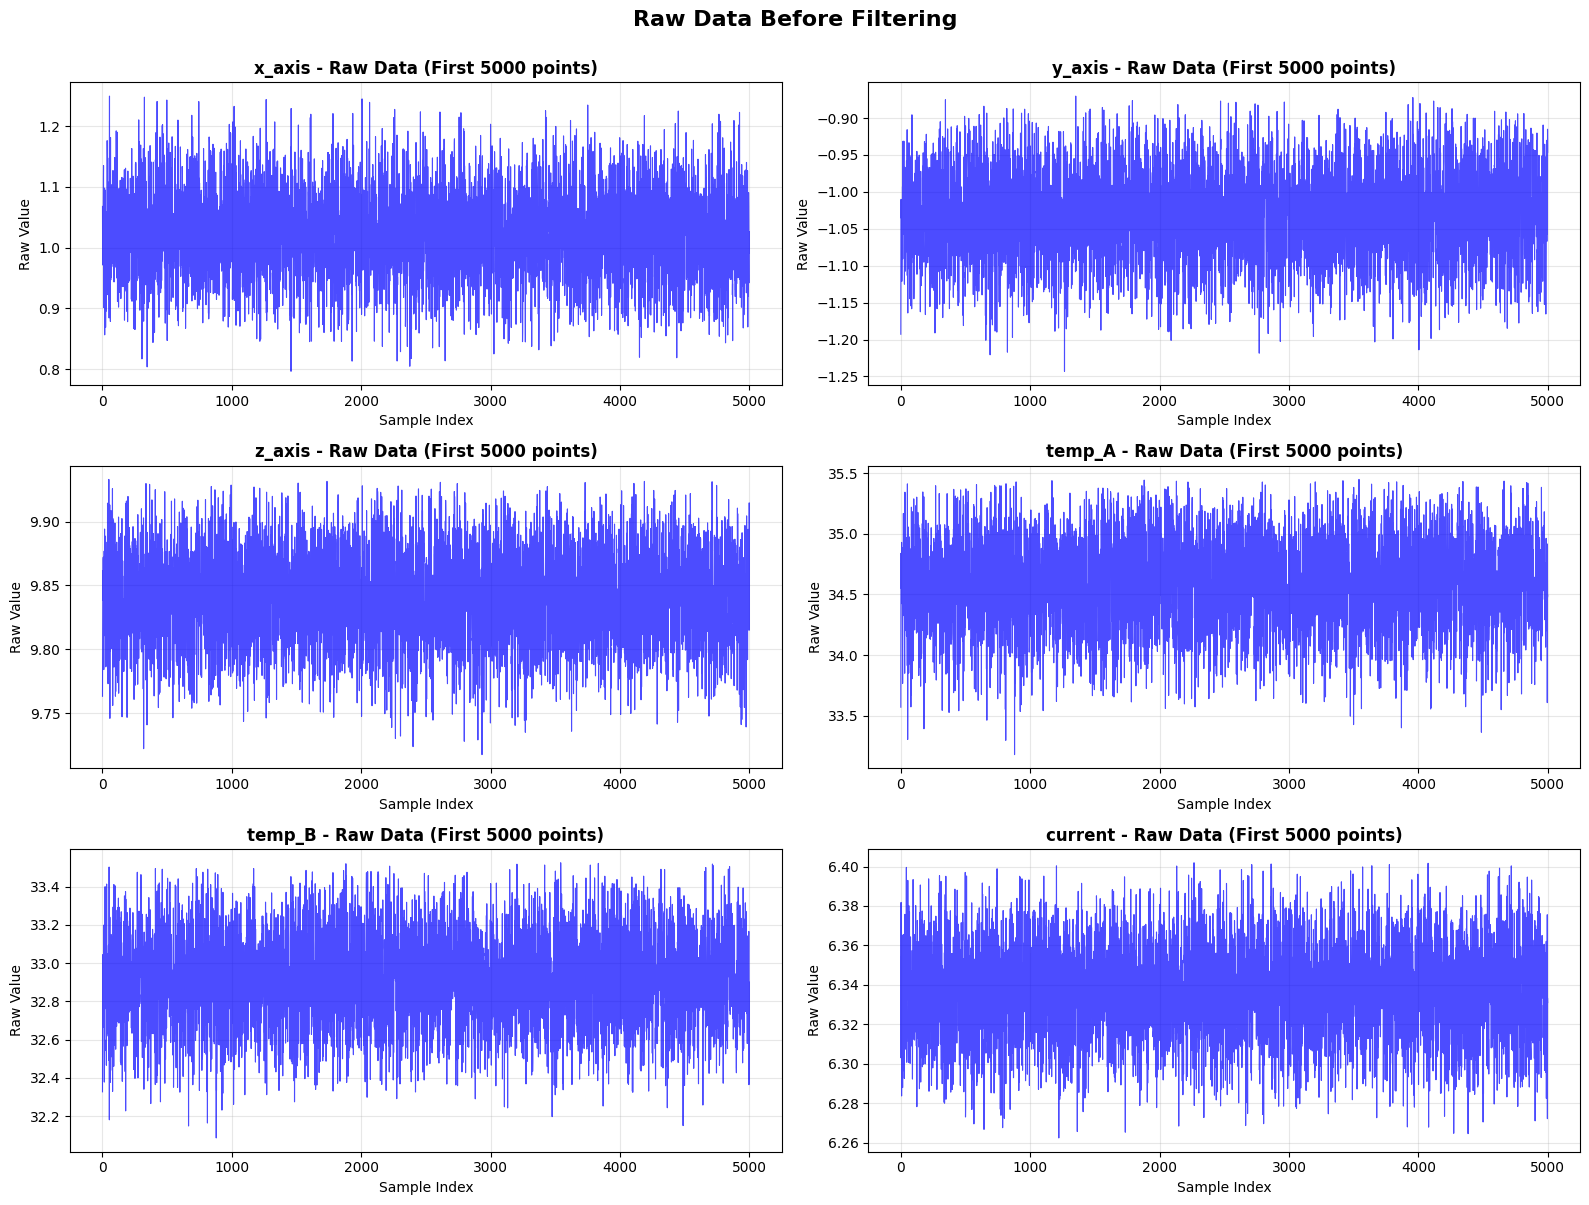


Raw Data Statistics:
             x_axis        y_axis        z_axis        temp_A        temp_B  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       1.025643     -1.031374      9.840835     34.581459     32.921902   
std        0.075800      0.062187      0.036997      0.372610      0.241781   
min        0.794481     -1.257501      9.704371     33.179665     32.078812   
25%        0.972442     -1.073528      9.815816     34.326531     32.761199   
50%        1.025573     -1.029748      9.841884     34.600500     32.930307   
75%        1.078871     -0.987501      9.866873     34.849221     33.088567   
max        1.255386     -0.868549      9.938916     35.454140     33.529408   

            current  
count  70000.000000  
mean       6.336523  
std        0.024391  
min        6.261493  
25%        6.319409  
50%        6.336341  
75%        6.353798  
max        6.403013  


In [ ]:
# ✅ STEP 1: VISUALIZE RAW DATA (Before Filtering)
print("\n" + "="*80)
print("STEP 1: RAW DATA VISUALIZATION")
print("="*80)

# Plot raw data for all features
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot first 5000 points (or all if less)
    plot_points = min(5000, len(data))
    ax.plot(range(plot_points), data[:plot_points, i],
            color='blue', alpha=0.7, linewidth=0.8)
    ax.set_title(f'{col} - Raw Data (First {plot_points} points)',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Raw Value')
    ax.grid(True, alpha=0.3)

plt.suptitle('Raw Data Before Filtering', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nRaw Data Statistics:")
print(pd.DataFrame(data, columns=feature_cols).describe())

In [ ]:
# ✅ STEP 2: APPLY BUTTERWORTH FILTER
print("\n" + "="*80)
print("STEP 2: APPLYING BUTTERWORTH LOW-PASS FILTER")
print("="*80)

from scipy.signal import butter, filtfilt

def butterworth_filter(data, cutoff_freq=0.1, order=4, fs=1.0):
    """
    Apply Butterworth low-pass filter to remove high-frequency noise

    Parameters:
    -----------
    data : array
        Input signal
    cutoff_freq : float
        Cutoff frequency (normalized, 0 to 1)
    order : int
        Filter order (higher = sharper cutoff)
    fs : float
        Sampling frequency
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Apply Butterworth filter to all features
print("Filtering data with Butterworth low-pass filter...")
print(f"Parameters: cutoff_freq=0.1, order=4")

data_filtered = butterworth_filter(data, cutoff_freq=0.3, order=2)

print(f"✅ Filtering complete!")
print(f"Original data shape: {data.shape}")
print(f"Filtered data shape: {data_filtered.shape}")


STEP 2: APPLYING BUTTERWORTH LOW-PASS FILTER
Filtering data with Butterworth low-pass filter...
Parameters: cutoff_freq=0.1, order=4
✅ Filtering complete!
Original data shape: (70000, 6)
Filtered data shape: (70000, 6)



STEP 3: FILTERED DATA VISUALIZATION


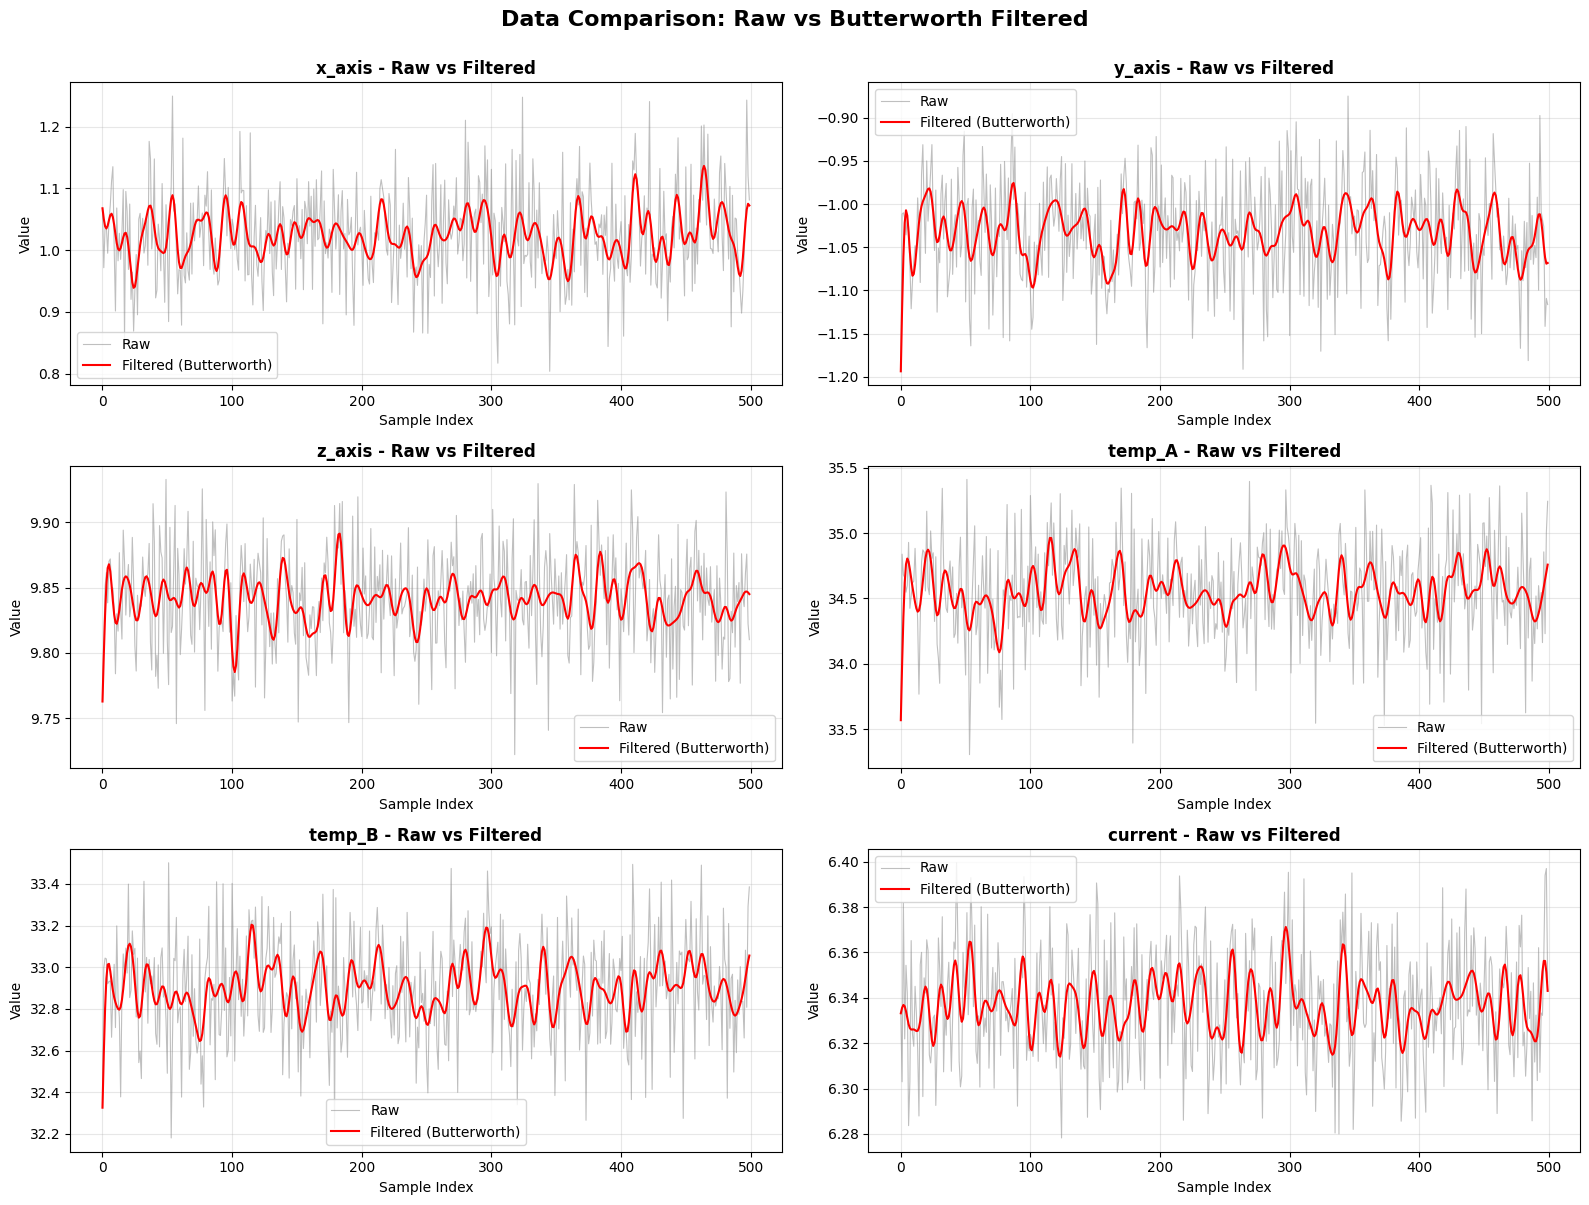


Filtered Data Statistics:
             x_axis        y_axis        z_axis        temp_A        temp_B  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       1.025645     -1.031376      9.840835     34.581452     32.921899   
std        0.032169      0.026543      0.015735      0.157724      0.102283   
min        0.905490     -1.193477      9.762812     33.567821     32.326246   
25%        1.004059     -1.049424      9.830272     34.474655     32.852418   
50%        1.025519     -1.031140      9.840988     34.583419     32.922378   
75%        1.047254     -1.013094      9.851505     34.689254     32.991557   
max        1.167837     -0.925090      9.917573     35.219749     33.344560   

            current  
count  70000.000000  
mean       6.336523  
std        0.010410  
min        6.289872  
25%        6.329532  
50%        6.336593  
75%        6.343608  
max        6.379825  

📊 Noise Reduction Metrics:
x_axis         : SNR =  23.75 dB, N

In [ ]:
# ✅ STEP 3: VISUALIZE FILTERED DATA (After Butterworth)
print("\n" + "="*80)
print("STEP 3: FILTERED DATA VISUALIZATION")
print("="*80)

# Plot filtered data comparison
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

plot_points = min(500, len(data))

for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot raw and filtered data
    ax.plot(range(plot_points), data[:plot_points, i],
            label='Raw', alpha=0.5, linewidth=0.8, color='gray')
    ax.plot(range(plot_points), data_filtered[:plot_points, i],
            label='Filtered (Butterworth)', linewidth=1.5, color='red')

    ax.set_title(f'{col} - Raw vs Filtered', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Data Comparison: Raw vs Butterworth Filtered',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print filtered data statistics
print(f"\nFiltered Data Statistics:")
print(pd.DataFrame(data_filtered, columns=feature_cols).describe())

# Calculate noise reduction metrics
print(f"\n📊 Noise Reduction Metrics:")
for i, col in enumerate(feature_cols):
    noise = data[:, i] - data_filtered[:, i]
    noise_power = np.mean(noise ** 2)
    signal_power = np.mean(data_filtered[:, i] ** 2)

    if noise_power > 0:
        snr = 10 * np.log10(signal_power / noise_power)
        print(f"{col:15s}: SNR = {snr:6.2f} dB, Noise Std = {np.std(noise):.6f}")
    else:
        print(f"{col:15s}: SNR = inf dB (no noise)")

✅ Applied StandardScaler to filtered data
Scaled mean: -0.000000 (should be ~0)
Scaled std: 1.000000 (should be ~1)
Selected feature column names: ['x_axis', 'y_axis', 'z_axis', 'temp_A', 'temp_B', 'current']
Original data shape: (70000, 6)
Scaled data shape: (70000, 6)

STEP 1: RAW DATA (First 500 rows)
       x_axis    y_axis    z_axis     temp_A     temp_B   current
0    1.067945 -1.192841  9.763134  33.570596  32.327205  6.333085
1    0.971583 -1.011655  9.808537  34.838483  32.996848  6.302974
2    1.038260 -1.010083  9.850902  34.679960  33.044087  6.381788
3    1.038304 -1.016263  9.861589  34.659109  33.039952  6.321854
4    0.995041 -1.035656  9.838428  34.547609  32.921033  6.354338
..        ...       ...       ...        ...        ...       ...
495  0.991143 -1.018068  9.835506  34.161558  32.660677  6.332265
496  1.050047 -1.026117  9.861161  34.856019  33.082216  6.356805
497  1.243266 -1.141530  9.875786  34.229885  32.808002  6.393984
498  1.120397 -1.109162  9.822434 

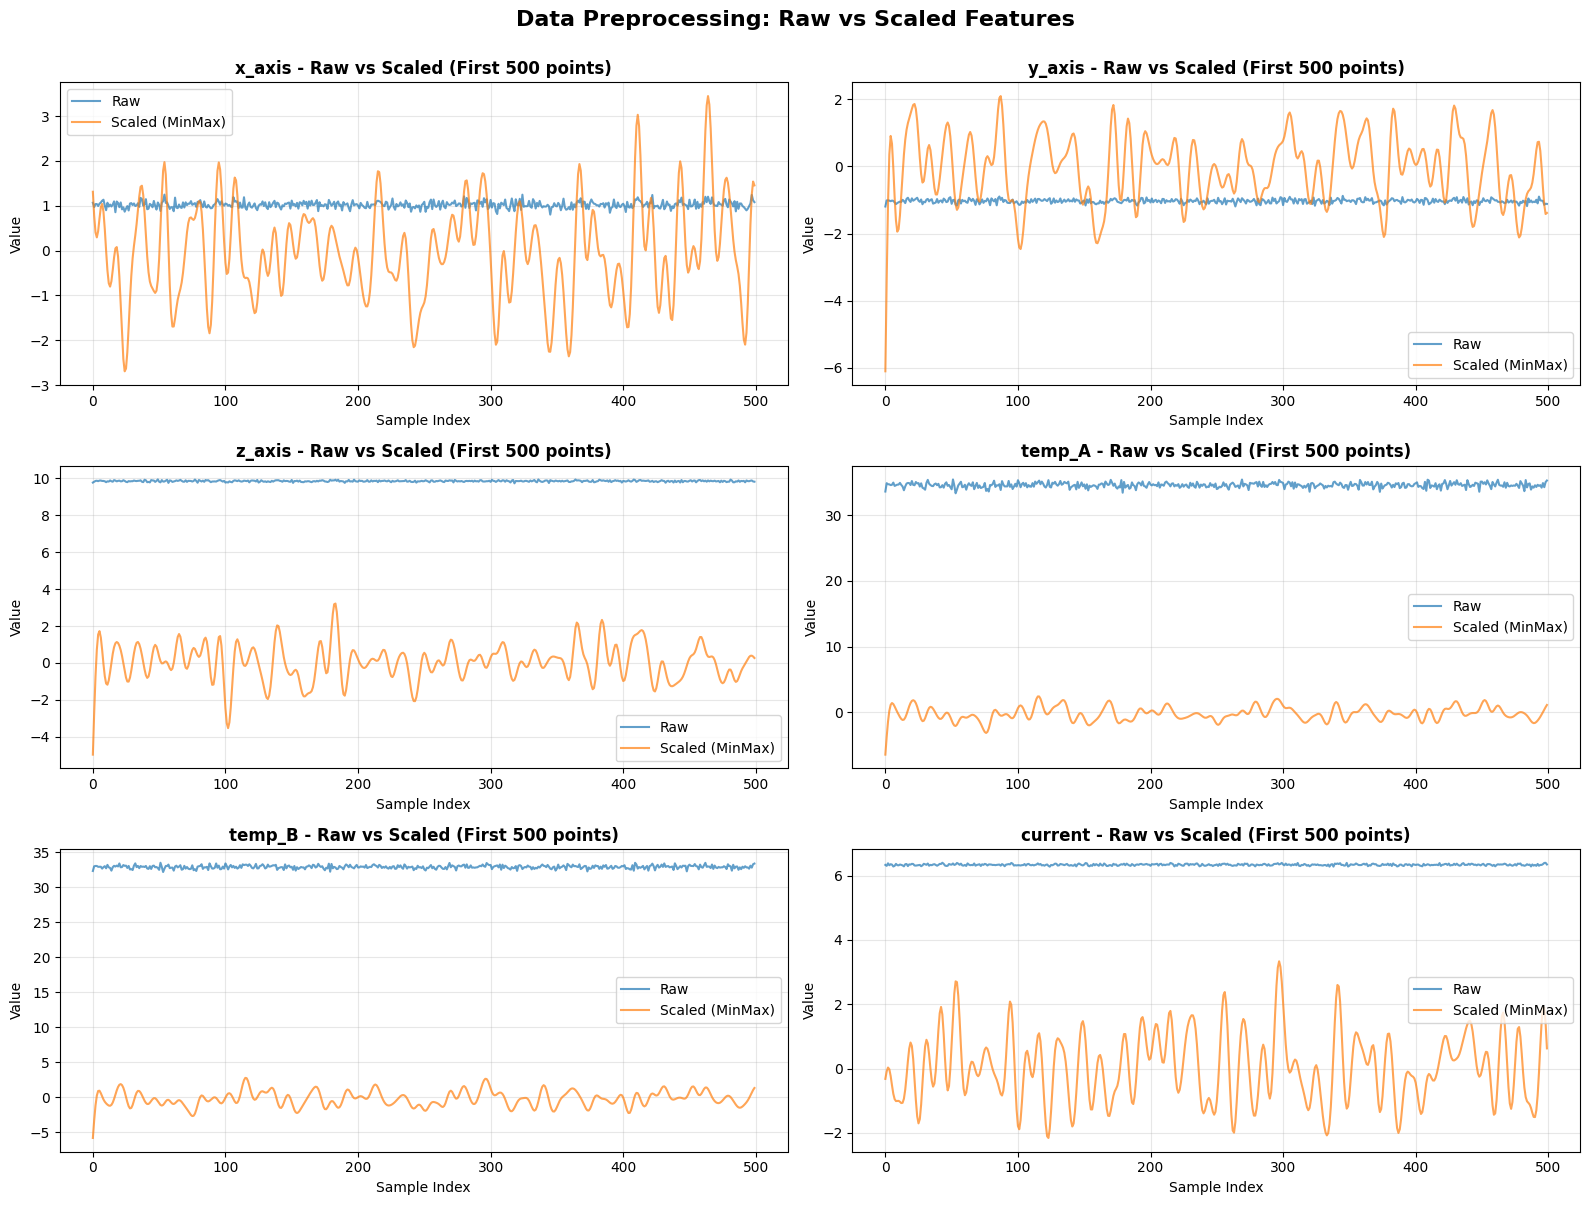


✅ Data loading and scaling complete!


In [ ]:
from sklearn.preprocessing import RobustScaler

# ✅ OPTION 1: RobustScaler (Better for data with outliers)
# Uses median and IQR instead of mean/std - preserves variance better
# scaler = RobustScaler()
# data_scaled = scaler.fit_transform(data).astype(np.float32)

# ✅ OPTION 2: StandardScaler with feature-wise scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered).astype(np.float32)
print("✅ Applied StandardScaler to filtered data")
print(f"Scaled mean: {data_scaled.mean():.6f} (should be ~0)")
print(f"Scaled std: {data_scaled.std():.6f} (should be ~1)")

# ✅ OPTION 3: Per-feature MinMaxScaler (if you must use MinMax)
# scaler = MinMaxScaler()
# This preserves relative variance better than global scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))  # Centered at 0
# data_scaled = scaler.fit_transform(data).astype(np.float32)

# ✅ OPTION 4: No scaling (let model learn raw patterns)
# scaler = None
# data_scaled = data_filtered.astype(np.float32)
# # If using no scaling, update model config: scaling="mean" or scaling="std"






# Print full shape and column names
print("Selected feature column names:", feature_cols)
print("Original data shape:", data.shape)
print("Scaled data shape:", data_scaled.shape)

# ✅ STEP 1: Print first 500 data points (RAW DATA)
print("\n" + "="*80)
print("STEP 1: RAW DATA (First 500 rows)")
print("="*80)
print(df[feature_cols].head(500))
print(f"\nRaw data statistics:\n{df[feature_cols].describe()}")

# ✅ STEP 2: Print first 500 data points (SCALED DATA)
print("\n" + "="*80)
print("STEP 2: SCALED DATA (First 500 rows)")
print("="*80)
df_scaled = pd.DataFrame(data_scaled[:500], columns=feature_cols)
print(df_scaled)
print(f"\nScaled data statistics:\n{df_scaled.describe()}")

# ✅ VISUALIZATION: Plot raw vs scaled data
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot first 500 points
    ax.plot(data[:500, i], label='Raw', alpha=0.7, linewidth=1.5)
    ax.plot(data_scaled[:500, i], label='Scaled (MinMax)', alpha=0.7, linewidth=1.5)
    ax.set_title(f'{col} - Raw vs Scaled (First 500 points)', fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Data Preprocessing: Raw vs Scaled Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Data loading and scaling complete!")

Train windows: (48821, 160, 6) (48821, 20, 6)
Val windows: (10321, 160, 6) (10321, 20, 6)
Test windows: (10321, 160, 6) (10321, 20, 6)

STEP 3: TRAIN/VAL/TEST SPLITS (First 500 samples from each)

Train series shape: (49000, 6)
Train series (first 500 rows):
       x_axis    y_axis    z_axis    temp_A    temp_B   current
0    1.312805 -6.107108 -4.958556 -6.426656 -5.823594 -0.321182
1    0.776164 -3.371442 -2.698796 -3.725142 -3.295921 -0.088375
2    0.404518 -1.103873 -0.726000 -1.415215 -1.183883  0.031347
3    0.294545  0.359170  0.728358  0.232564  0.233384 -0.021417
4    0.435378  0.911121  1.543809  1.142571  0.891526 -0.231957
..        ...       ...       ...       ...       ...       ...
495 -0.304015 -0.034992  0.324242 -0.335657 -0.124405  1.445242
496  0.588541 -0.633363  0.388895  0.036051  0.258992  1.897539
497  1.250889 -1.144497  0.395517  0.419940  0.658044  1.895647
498  1.540767 -1.417093  0.350819  0.789398  1.023078  1.422307
499  1.455446 -1.384778  0.270807  1.

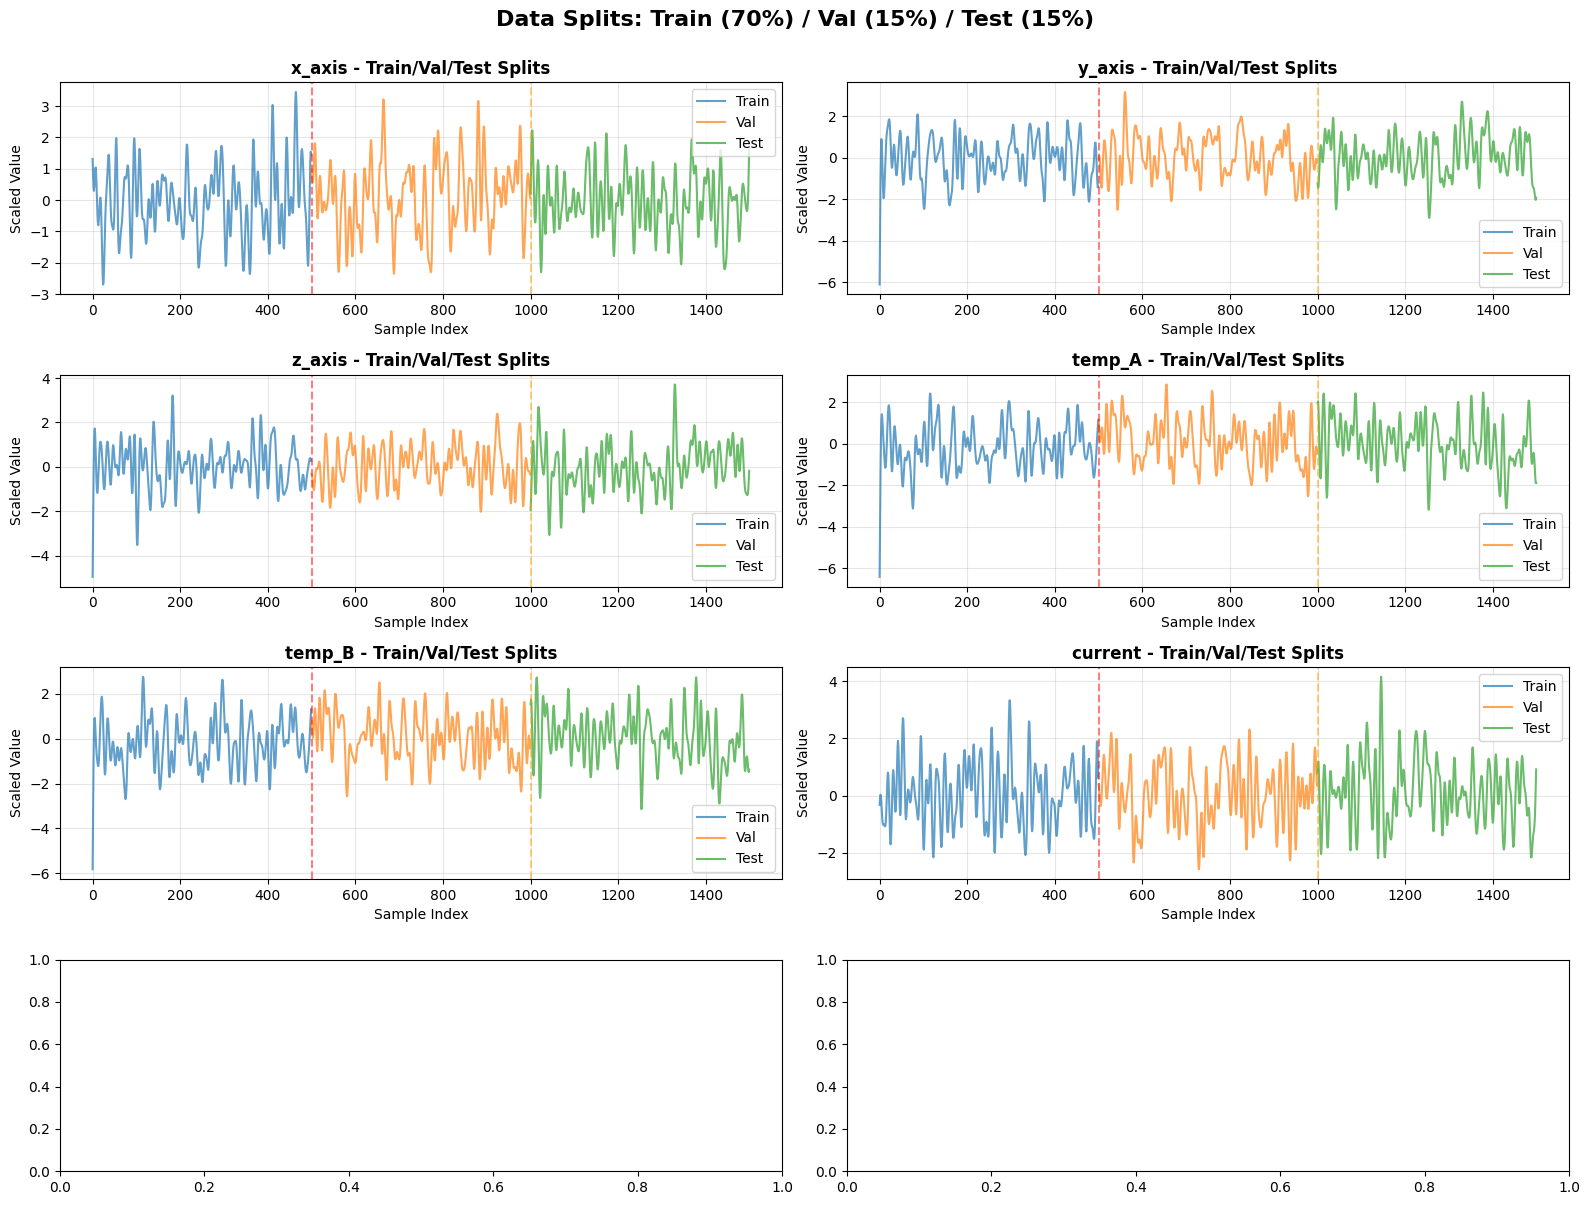

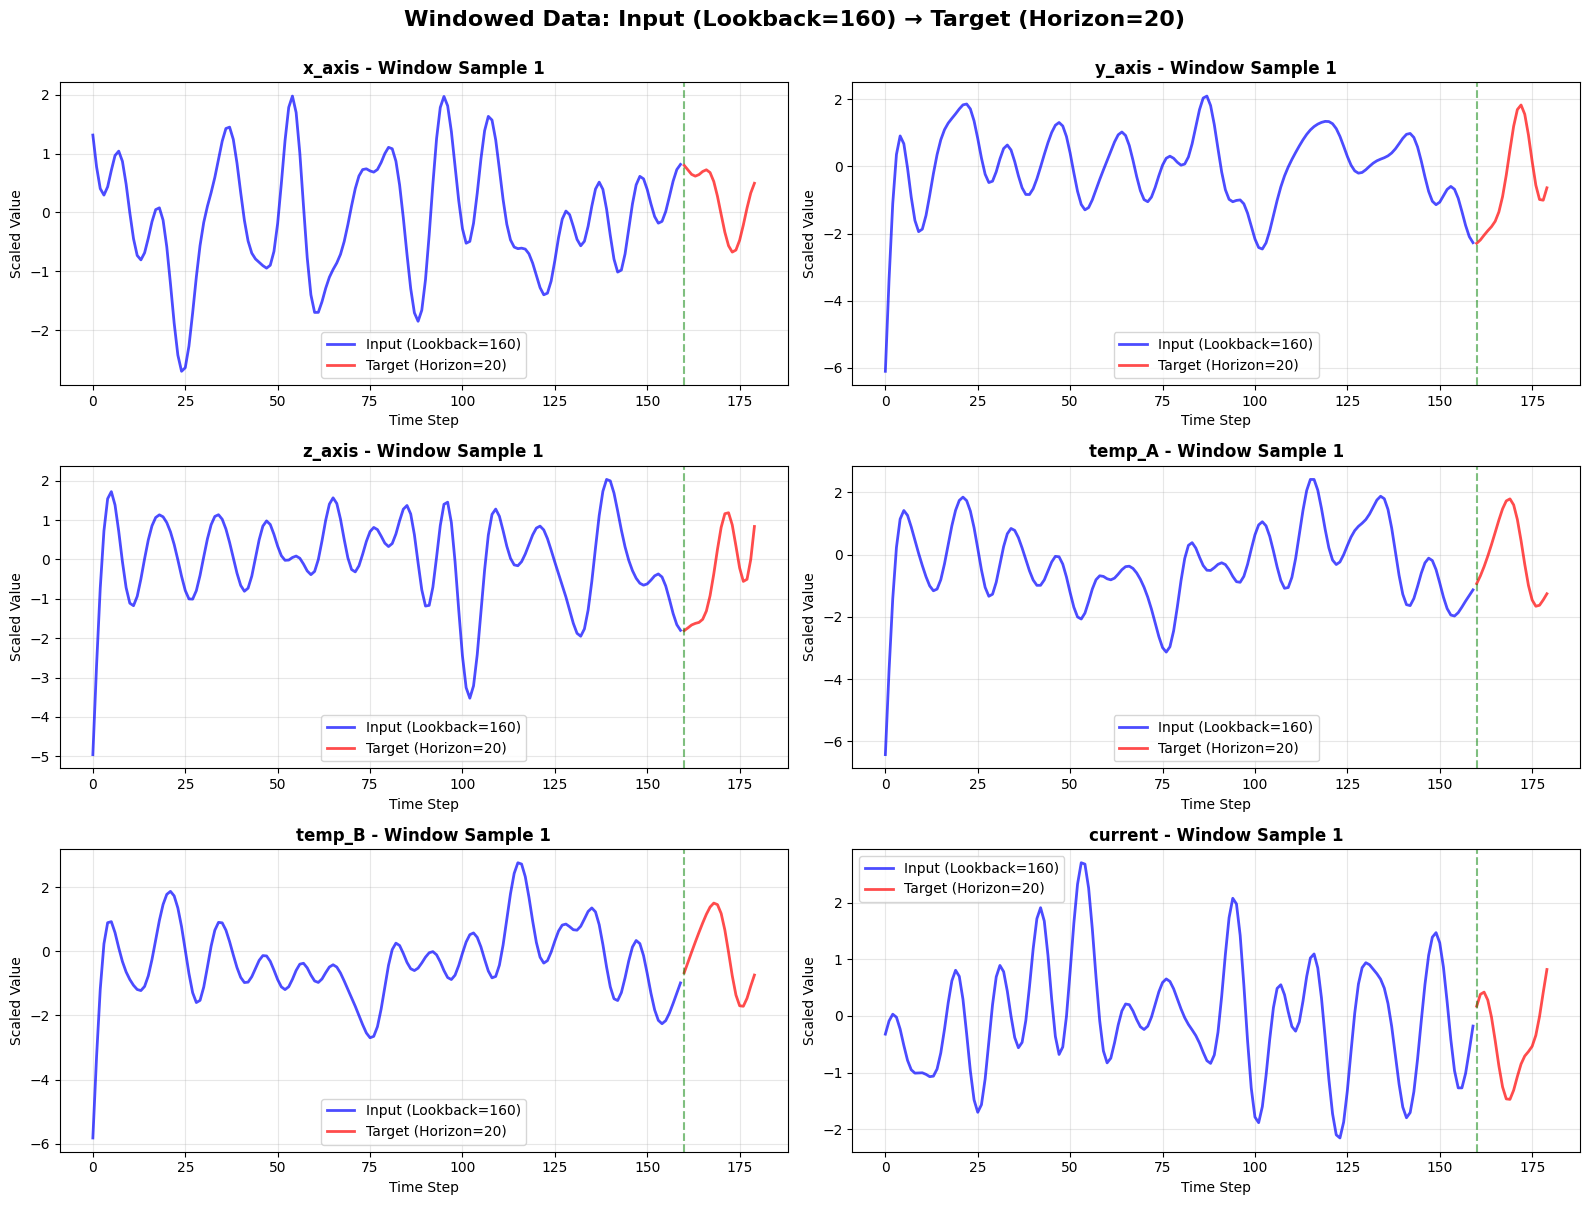


✅ Data windowing complete!


In [ ]:
# Hyperparameters
context_length = 160        # lookback window
prediction_length = 20      # forecast horizon
num_features = data_scaled.shape[1]  # 8

# Splits (70/15/15)
N = data_scaled.shape[0]
n_train = int(0.7 * N)
n_val = int(0.15 * N)
train_series = data_scaled[:n_train]
val_series   = data_scaled[n_train:n_train + n_val]
test_series  = data_scaled[n_train + n_val:]

def build_windows(arr, context_len, pred_len):
    X_list, Y_list = [], []
    T = arr.shape[0]
    for start in range(0, T - context_len - pred_len + 1):
        end_ctx = start + context_len
        end_pred = end_ctx + pred_len
        X_list.append(arr[start:end_ctx])      # (context_len, C)
        Y_list.append(arr[end_ctx:end_pred])   # (pred_len, C)
    X = np.stack(X_list, axis=0) if X_list else np.empty((0, context_len, arr.shape[1]), dtype=np.float32)
    Y = np.stack(Y_list, axis=0) if Y_list else np.empty((0, pred_len, arr.shape[1]), dtype=np.float32)
    return X.astype(np.float32), Y.astype(np.float32)

X_train_np, y_train_np = build_windows(train_series, context_length, prediction_length)
X_val_np,   y_val_np   = build_windows(val_series,   context_length, prediction_length)
X_test_np,  y_test_np  = build_windows(test_series,  context_length, prediction_length)

print("Train windows:", X_train_np.shape, y_train_np.shape)
print("Val windows:",   X_val_np.shape,   y_val_np.shape)
print("Test windows:",  X_test_np.shape,  y_test_np.shape)

# ✅ STEP 3: Print first 500 samples from train/val/test splits
print("\n" + "="*80)
print("STEP 3: TRAIN/VAL/TEST SPLITS (First 500 samples from each)")
print("="*80)
print(f"\nTrain series shape: {train_series.shape}")
print(f"Train series (first 500 rows):\n{pd.DataFrame(train_series[:500], columns=feature_cols)}")
print(f"\nVal series shape: {val_series.shape}")
print(f"Val series (first 500 rows):\n{pd.DataFrame(val_series[:500], columns=feature_cols)}")
print(f"\nTest series shape: {test_series.shape}")
print(f"Test series (first 500 rows):\n{pd.DataFrame(test_series[:500], columns=feature_cols)}")

# ✅ STEP 4: Print windowed data samples
print("\n" + "="*80)
print("STEP 4: WINDOWED DATA (First 5 windows)")
print("="*80)
print(f"\nX_train (input windows) - First 5 windows:")
for i in range(min(5, len(X_train_np))):
    print(f"\nWindow {i+1} shape: {X_train_np[i].shape}")
    print(f"First 10 timesteps:\n{pd.DataFrame(X_train_np[i][:10], columns=feature_cols)}")
    print(f"Last 10 timesteps:\n{pd.DataFrame(X_train_np[i][-10:], columns=feature_cols)}")

print(f"\ny_train (target windows) - First 5 windows:")
for i in range(min(5, len(y_train_np))):
    print(f"\nTarget {i+1} shape: {y_train_np[i].shape}")
    print(f"All {prediction_length} target timesteps:\n{pd.DataFrame(y_train_np[i], columns=feature_cols)}")

# ✅ VISUALIZATION: Plot train/val/test splits
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot first 500 points from each split
    train_plot = train_series[:500, i]
    val_plot = val_series[:min(500, len(val_series)), i]
    test_plot = test_series[:min(500, len(test_series)), i]

    ax.plot(range(len(train_plot)), train_plot, label='Train', alpha=0.7, linewidth=1.5)
    ax.plot(range(len(train_plot), len(train_plot) + len(val_plot)), val_plot,
            label='Val', alpha=0.7, linewidth=1.5)
    ax.plot(range(len(train_plot) + len(val_plot), len(train_plot) + len(val_plot) + len(test_plot)),
            test_plot, label='Test', alpha=0.7, linewidth=1.5)

    ax.set_title(f'{col} - Train/Val/Test Splits', fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Scaled Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(x=len(train_plot), color='red', linestyle='--', alpha=0.5)
    ax.axvline(x=len(train_plot) + len(val_plot), color='orange', linestyle='--', alpha=0.5)

plt.suptitle('Data Splits: Train (70%) / Val (15%) / Test (15%)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ✅ VISUALIZATION: Sample windowed input-output pairs
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

sample_idx = 0  # First window
for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot input window (context)
    input_window = X_train_np[sample_idx, :, i]
    target_window = y_train_np[sample_idx, :, i]

    ax.plot(range(context_length), input_window, label=f'Input (Lookback={context_length})',
            alpha=0.7, linewidth=2, color='blue')
    ax.plot(range(context_length, context_length + prediction_length), target_window,
            label=f'Target (Horizon={prediction_length})', alpha=0.7, linewidth=2, color='red')

    ax.set_title(f'{col} - Window Sample {sample_idx+1}', fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Scaled Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(x=context_length, color='green', linestyle='--', alpha=0.5, label='Forecast Start')

plt.suptitle(f'Windowed Data: Input (Lookback={context_length}) → Target (Horizon={prediction_length})',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Data windowing complete!")

In [ ]:
class PatchWindowDataset(Dataset):
    def __init__(self, X_np, Y_np):
        self.X = torch.from_numpy(X_np)  # (N, L, C)
        self.Y = torch.from_numpy(Y_np)  # (N, T, C)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return {
            "past_values": self.X[idx],
            "future_values": self.Y[idx]
        }

train_ds = PatchWindowDataset(X_train_np, y_train_np)
val_ds   = PatchWindowDataset(X_val_np,   y_val_np)
test_ds  = PatchWindowDataset(X_test_np,  y_test_np)


In [ ]:
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/"

In [ ]:
from transformers import Trainer

class CustomTrainer(Trainer):
    """Custom trainer with variance-preserving loss."""

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # ✅ FIX 1: Added num_items_in_batch parameter

        # Get model outputs
        outputs = model(**inputs)
        predictions = outputs.prediction_outputs

        # Get targets - handle both tensor and tuple cases
        targets = inputs["future_values"]

        # ✅ FIX 2: If targets is a tuple, extract the first element
        if isinstance(targets, tuple):
            targets = targets[0]

        # Compute custom loss
        loss = custom_loss_fn(predictions, targets)

        return (loss, outputs) if return_outputs else loss

In [ ]:
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_length=12,
    patch_stride=4,                  # preserve fine-grained temporal info
    num_input_channels=num_features, # 8
    num_targets=num_features,        # multivariate forecast
    d_model=512,                      # 512
    num_attention_heads=8,            # 8
    num_hidden_layers=6,              # 6
    ffn_dim=1024,                     # 2048
    dropout=0.1,        # ✅ REDUCED from 0.2 (less regularization)
    head_dropout=0.1,   # ✅ REDUCED from 0.2 (allows more variance)
    pooling_type=None,
    channel_attention=False,
    # scaling='std',
    scaling=None,
    # loss="mae",
    loss="mse",
    activation_function="gelu",
    pre_norm=True,
    norm_type="batchnorm"
)

model = PatchTSTForPrediction(config).to(device)

# training_args = TrainingArguments(
#     # output_dir="./checkpoints/patchtst_sensor/",
#     output_dir=os.path.join(model_paths, "checkpoints/patchtst_sensor"),
#     overwrite_output_dir=True,
#     learning_rate=5e-4,
#     num_train_epochs=10,
#     do_eval=True,
#     eval_strategy="epoch",
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     dataloader_num_workers=2,
#     save_strategy="epoch",
#     logging_strategy="epoch",
#     save_total_limit=3,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     label_names=["future_values"],
#     report_to="none",
# )
# REPLACE the existing TrainingArguments with this:












# 🔍 DEBUG: Test model forward pass
print("\n" + "="*80)
print("🔍 PRE-TRAINING DEBUG CHECK")
print("="*80)

# Get a sample batch
sample_batch = next(iter(torch.utils.data.DataLoader(train_ds, batch_size=2)))
sample_past = sample_batch["past_values"].to(device)
sample_future = sample_batch["future_values"].to(device)

print(f"\nInput shape: {sample_past.shape}")
print(f"Target shape: {sample_future.shape}")

# Test model forward pass
with torch.no_grad():
    outputs = model(past_values=sample_past)
    preds = outputs.prediction_outputs

    if isinstance(preds, tuple):
        preds = preds[0]

    print(f"\nOutput shape: {preds.shape}")
    print(f"Output dtype: {preds.dtype}")
    print(f"Output device: {preds.device}")

    # Check if outputs are reasonable
    print(f"\nOutput statistics:")
    print(f"  Mean: {preds.mean():.6f}")
    print(f"  Std: {preds.std():.6f}")
    print(f"  Min: {preds.min():.6f}")
    print(f"  Max: {preds.max():.6f}")

    # Test loss calculation
    mae_loss = torch.nn.functional.l1_loss(preds, sample_future)
    mse_loss = torch.nn.functional.mse_loss(preds, sample_future)

    print(f"\nManual loss calculation:")
    print(f"  MAE Loss: {mae_loss.item():.6f}")
    print(f"  MSE Loss: {mse_loss.item():.6f}")

    if mae_loss < 0 or mse_loss < 0:
        print("🚨 ERROR: Loss is negative! This should never happen!")
    else:
        print("✅ Loss calculation looks OK")

print("="*80)





















from transformers import TrainingArguments, get_cosine_schedule_with_warmup

training_args = TrainingArguments(
    output_dir=os.path.join(model_paths, "checkpoints/patchtst_sensor"),
    overwrite_output_dir=True,

    # ✅ STRATEGY 1: Higher initial learning rate with warmup
    learning_rate=1e-4,              # Increased from 5e-4
    warmup_steps=100,                # Gradual warmup

    # ✅ STRATEGY 2: Use learning rate scheduler
    lr_scheduler_type="cosine",      # Cosine annealing
    # Options: "linear", "cosine", "cosine_with_restarts", "polynomial"

    num_train_epochs=20,             # More epochs with scheduler
    do_eval=True,
    eval_strategy="epoch",

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_num_workers=2,

    save_strategy="epoch",
    logging_strategy="steps",       # ✅ Log every N steps, not just epochs
    logging_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    label_names=["future_values"],
    report_to="none",

    # ✅ STRATEGY 3: Weight decay for regularization
    weight_decay=0.01,               # Helps escape local minima

    # ✅ STRATEGY 4: Gradient clipping
    max_grad_norm=1.0,               # Prevents gradient explosion
)




early_stop = EarlyStoppingCallback(
    early_stopping_patience=10,
    early_stopping_threshold=1e-4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    callbacks=[early_stop],
)
# # Use CustomTrainer instead of Trainer
# trainer = CustomTrainer(  # ✅ CHANGED FROM Trainer to CustomTrainer
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     callbacks=[early_stop],
# )



🔍 PRE-TRAINING DEBUG CHECK

Input shape: torch.Size([2, 160, 6])
Target shape: torch.Size([2, 20, 6])

Output shape: torch.Size([2, 20, 6])
Output dtype: torch.float32
Output device: cuda:0

Output statistics:
  Mean: -0.085586
  Std: 1.266062
  Min: -2.942786
  Max: 3.401737

Manual loss calculation:
  MAE Loss: 1.231851
  MSE Loss: 2.361112
✅ Loss calculation looks OK


In [ ]:
# NEW CELL: Verify Loss Function Works Correctly

print("\n" + "="*80)
print("🔍 LOSS FUNCTION VERIFICATION")
print("="*80)

# Get a test batch
sample_batch = next(iter(torch.utils.data.DataLoader(train_ds, batch_size=4)))
sample_past = sample_batch["past_values"].to(device)
sample_future = sample_batch["future_values"].to(device)

# Test forward pass + loss
model.train()
with torch.no_grad():
    outputs = model(
        past_values=sample_past,
        future_values=sample_future  # Include targets
    )

    # Extract predictions and loss
    preds = outputs.prediction_outputs
    if isinstance(preds, tuple):
        preds = preds[0]

    # Manual loss calculation
    manual_mse = torch.nn.functional.mse_loss(preds, sample_future)
    manual_mae = torch.nn.functional.l1_loss(preds, sample_future)

    # Model's internal loss (if available)
    model_loss = outputs.loss if hasattr(outputs, 'loss') else None

print(f"\n📊 Loss Values:")
print(f"  Manual MSE Loss:  {manual_mse.item():.6f}")
print(f"  Manual MAE Loss:  {manual_mae.item():.6f}")
if model_loss is not None:
    print(f"  Model's Internal Loss: {model_loss.item():.6f}")
    if model_loss.item() < 0:
        print("  🚨 ERROR: Loss is still negative!")
    else:
        print("  ✅ Loss is positive (good!)")
else:
    print("  ℹ️ Model doesn't compute internal loss")

print(f"\n📈 Prediction Statistics:")
print(f"  Pred Mean:  {preds.mean():.6f}")
print(f"  Pred Std:   {preds.std():.6f}")
print(f"  Target Mean: {sample_future.mean():.6f}")
print(f"  Target Std:  {sample_future.std():.6f}")

# Check if predictions are reasonable
if preds.std() > 100 * sample_future.std():
    print("\n🚨 WARNING: Predictions have extremely high variance!")
    print("   Model might still be outputting noise.")
else:
    print("\n✅ Prediction variance looks reasonable")

print("="*80)


🔍 LOSS FUNCTION VERIFICATION

📊 Loss Values:
  Manual MSE Loss:  2.547621
  Manual MAE Loss:  1.304652
  Model's Internal Loss: 2.547621
  ✅ Loss is positive (good!)

📈 Prediction Statistics:
  Pred Mean:  -0.064203
  Pred Std:   1.322456
  Target Mean: -0.111739
  Target Std:  1.056589

✅ Prediction variance looks reasonable


In [ ]:
torch.cuda.empty_cache()
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.754700,0.791008
2,0.719200,0.754208
3,0.726300,0.725445
4,0.702500,0.741603
5,0.687000,0.769029
6,0.694000,0.721342
7,0.709300,0.926780
8,0.677400,0.711562
9,0.667400,1.057277
10,0.661600,0.712949


TrainOutput(global_step=61040, training_loss=0.6840341117091447, metrics={'train_runtime': 1981.4573, 'train_samples_per_second': 492.779, 'train_steps_per_second': 30.806, 'total_flos': 7.32940558705152e+16, 'train_loss': 0.6840341117091447, 'epoch': 20.0})

In [ ]:
print("\n🔍 Model parameter statistics:")
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean():.4f}, std={param.std():.4f}, max={param.max():.4f}")


🔍 Model parameter statistics:
model.encoder.embedder.input_embedding.weight: mean=-0.0003, std=0.0211, max=0.0849
model.encoder.embedder.input_embedding.bias: mean=0.0001, std=0.0047, max=0.0088
model.encoder.positional_encoder.position_enc: mean=0.0000, std=0.1000, max=0.1024
model.encoder.layers.0.self_attn.k_proj.weight: mean=0.0000, std=0.0201, max=0.1558
model.encoder.layers.0.self_attn.k_proj.bias: mean=-0.0000, std=0.0000, max=0.0000
model.encoder.layers.0.self_attn.v_proj.weight: mean=0.0000, std=0.0198, max=0.0990
model.encoder.layers.0.self_attn.v_proj.bias: mean=-0.0000, std=0.0042, max=0.0184
model.encoder.layers.0.self_attn.q_proj.weight: mean=-0.0000, std=0.0207, max=0.2411
model.encoder.layers.0.self_attn.q_proj.bias: mean=-0.0005, std=0.0157, max=0.0529
model.encoder.layers.0.self_attn.out_proj.weight: mean=0.0000, std=0.0194, max=0.0955
model.encoder.layers.0.self_attn.out_proj.bias: mean=0.0001, std=0.0047, max=0.0088
model.encoder.layers.0.norm_sublayer1.batchnorm.w

In [ ]:
# NEW CELL: Monitor variance metrics

def evaluate_variance_metrics(model, test_ds, device):
    """Evaluate how well model preserves variance."""
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(test_ds, batch_size=32):
            past = batch["past_values"].to(device)
            future = batch["future_values"].to(device)

            outputs = model(past_values=past)
            preds = outputs.prediction_outputs

            # ✅ FIX: Handle tuple output from model
            if isinstance(preds, tuple):
                preds = preds[0]  # Extract first element (predictions tensor)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(future.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)      # (N, horizon, features)
    all_targets = np.concatenate(all_targets, axis=0)

    print("\n" + "="*80)
    print("VARIANCE PRESERVATION METRICS")
    print("="*80)

    for feat_idx in range(num_features):
        pred_var = np.var(all_preds[:, :, feat_idx])
        target_var = np.var(all_targets[:, :, feat_idx])
        ratio = pred_var / target_var if target_var > 0 else 0

        # ✅ ADDED: Check if ratio is reasonable
        ratio_status = "✅ GOOD" if 0.7 <= ratio <= 1.3 else "❌ BAD"
        # ✅ ADDED: Warn if variance is too high/low
        if ratio > 10:
            ratio_status = "🚨 TOO HIGH (Model outputting noise!)"
        elif ratio < 0.1:
            ratio_status = "🚨 TOO LOW (Flat predictions!)"

        print(f"\nFeature {feat_idx} ({feature_cols[feat_idx]}):")
        print(f"  Target Variance:     {target_var:.6f}")
        print(f"  Predicted Variance:  {pred_var:.6f}")
        print(f"  Variance Ratio:      {ratio:.4f} {ratio_status}")
        print(f"  Variance Ratio:      {ratio:.4f} {'✅ GOOD' if ratio > 0.7 else '❌ TOO LOW'}")

# Run evaluation
evaluate_variance_metrics(model, test_ds, device)


VARIANCE PRESERVATION METRICS

Feature 0 (x_axis):
  Target Variance:     1.015682
  Predicted Variance:  0.365404
  Variance Ratio:      0.3598 ❌ BAD
  Variance Ratio:      0.3598 ❌ TOO LOW

Feature 1 (y_axis):
  Target Variance:     0.990236
  Predicted Variance:  0.357276
  Variance Ratio:      0.3608 ❌ BAD
  Variance Ratio:      0.3608 ❌ TOO LOW

Feature 2 (z_axis):
  Target Variance:     1.001244
  Predicted Variance:  0.366388
  Variance Ratio:      0.3659 ❌ BAD
  Variance Ratio:      0.3659 ❌ TOO LOW

Feature 3 (temp_A):
  Target Variance:     1.025860
  Predicted Variance:  0.371357
  Variance Ratio:      0.3620 ❌ BAD
  Variance Ratio:      0.3620 ❌ TOO LOW

Feature 4 (temp_B):
  Target Variance:     1.023288
  Predicted Variance:  0.371444
  Variance Ratio:      0.3630 ❌ BAD
  Variance Ratio:      0.3630 ❌ TOO LOW

Feature 5 (current):
  Target Variance:     0.959589
  Predicted Variance:  0.350227
  Variance Ratio:      0.3650 ❌ BAD
  Variance Ratio:      0.3650 ❌ TOO LOW



STEP 4.5: TRAINING HISTORY ANALYSIS

Training completed: 610 training steps, 20 evaluation steps

Training Losses (First 20 steps):
  Step 1: Epoch 0.0327653997378768, Loss: 1.5456
  Step 2: Epoch 0.0655307994757536, Loss: 1.3149
  Step 3: Epoch 0.0982961992136304, Loss: 1.16
  Step 4: Epoch 0.1310615989515072, Loss: 1.0256
  Step 5: Epoch 0.16382699868938402, Loss: 0.9791
  Step 6: Epoch 0.1965923984272608, Loss: 0.9294
  Step 7: Epoch 0.22935779816513763, Loss: 0.8732
  Step 8: Epoch 0.2621231979030144, Loss: 0.8584
  Step 9: Epoch 0.2948885976408912, Loss: 0.8439
  Step 10: Epoch 0.32765399737876805, Loss: 0.8096
  Step 11: Epoch 0.36041939711664484, Loss: 0.8099
  Step 12: Epoch 0.3931847968545216, Loss: 0.7812
  Step 13: Epoch 0.4259501965923984, Loss: 0.7847
  Step 14: Epoch 0.45871559633027525, Loss: 0.7695
  Step 15: Epoch 0.49148099606815204, Loss: 0.778
  Step 16: Epoch 0.5242463958060288, Loss: 0.7836
  Step 17: Epoch 0.5570117955439057, Loss: 0.7755
  Step 18: Epoch 0.5897

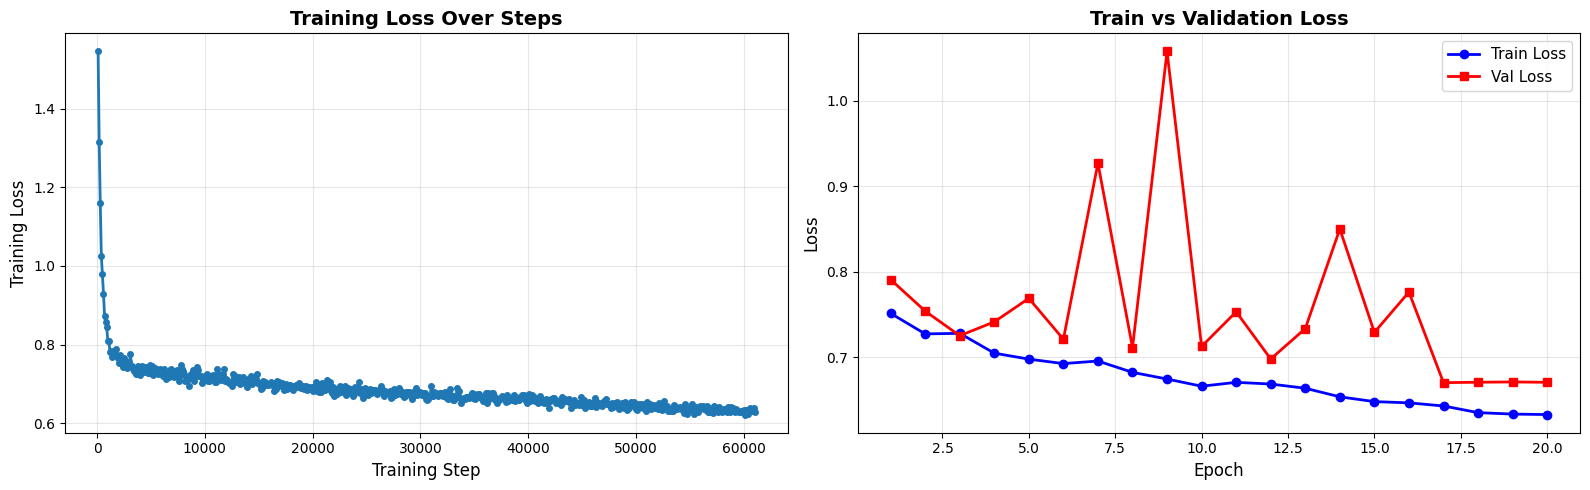


📊 Final Training Metrics:
  Final Train Loss: 0.633367
  Final Val Loss: 0.671021
  Train-Val Gap: 0.037654
  ✅ Train-val gap looks reasonable

✅ Training history analysis complete!


In [ ]:
# ✅ STEP 4.5: Visualize Training History
print("\n" + "="*80)
print("STEP 4.5: TRAINING HISTORY ANALYSIS")
print("="*80)

# Extract training logs
train_history = trainer.state.log_history

# Separate train and eval logs
train_logs = [log for log in train_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in train_history if 'eval_loss' in log]

print(f"\nTraining completed: {len(train_logs)} training steps, {len(eval_logs)} evaluation steps")

# Print training logs
if train_logs:
    print(f"\nTraining Losses (First {min(20, len(train_logs))} steps):")
    for i, log in enumerate(train_logs[:20]):
        epoch = log.get('epoch', 'N/A')
        loss = log.get('loss', 'N/A')
        print(f"  Step {i+1}: Epoch {epoch}, Loss: {loss}")

# Print eval logs
if eval_logs:
    print(f"\nValidation Losses:")
    for i, log in enumerate(eval_logs):
        epoch = log.get('epoch', 'N/A')
        eval_loss = log.get('eval_loss', 'N/A')
        print(f"  Evaluation {i+1}: Epoch {epoch}, Eval Loss: {eval_loss}")

# Plot training curves
if train_logs and eval_logs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Training loss over steps
    train_steps = [log.get('step', i) for i, log in enumerate(train_logs)]
    train_losses = [log.get('loss', 0) for log in train_logs]

    ax1.plot(train_steps, train_losses, marker='o', linewidth=2, markersize=4)
    ax1.set_xlabel('Training Step', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss Over Steps', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Train vs Validation loss
    eval_epochs = [log.get('epoch', i) for i, log in enumerate(eval_logs)]
    eval_losses = [log.get('eval_loss', 0) for log in eval_logs]

    # Match train losses to eval epochs
    train_epoch_losses = []
    for epoch in eval_epochs:
        matching_logs = [log['loss'] for log in train_logs if abs(log.get('epoch', 0) - epoch) < 0.1]
        if matching_logs:
            train_epoch_losses.append(np.mean(matching_logs))
        else:
            train_epoch_losses.append(None)

    ax2.plot(eval_epochs, train_epoch_losses, marker='o', linewidth=2,
             markersize=6, label='Train Loss', color='blue')
    ax2.plot(eval_epochs, eval_losses, marker='s', linewidth=2,
             markersize=6, label='Val Loss', color='red')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Check for overfitting
    if len(eval_losses) > 1:
        final_train = train_epoch_losses[-1] if train_epoch_losses[-1] is not None else 0
        final_val = eval_losses[-1]
        gap = final_val - final_train

        print(f"\n📊 Final Training Metrics:")
        print(f"  Final Train Loss: {final_train:.6f}")
        print(f"  Final Val Loss: {final_val:.6f}")
        print(f"  Train-Val Gap: {gap:.6f}")

        if gap > 0.1:
            print("  ⚠️ WARNING: Large train-val gap suggests overfitting!")
        elif gap < -0.05:
            print("  ⚠️ WARNING: Val loss lower than train loss (unusual)")
        else:
            print("  ✅ Train-val gap looks reasonable")
else:
    print("⚠️ Training history not available")

print("\n✅ Training history analysis complete!")

Test metrics: {'eval_loss': 0.6736156344413757, 'eval_runtime': 6.6467, 'eval_samples_per_second': 1552.806, 'eval_steps_per_second': 97.191, 'epoch': 20.0}

STEP 5: MODEL PREDICTIONS

Prediction shape: (20, 6)
Ground truth shape: (20, 6)

Predictions (First 20 timesteps):
            x_axis    y_axis    z_axis    temp_A    temp_B   current
Timestep                                                            
0        -0.912078  1.804770  1.189651  0.018624 -0.002236 -0.811787
1        -0.495581  1.369793  1.030380 -0.257774 -0.391765 -1.194388
2        -0.002958  0.624186  0.515124 -0.776534 -0.969197 -1.392552
3         0.577067 -0.256752 -0.165062 -1.324803 -1.523783 -1.346953
4         1.105172 -1.074206 -0.843810 -1.754930 -1.886745 -1.118805
5         1.418734 -1.644329 -1.292894 -1.846987 -1.887999 -0.689098
6         1.493133 -1.810097 -1.447001 -1.704100 -1.609956 -0.283553
7         1.325542 -1.617345 -1.225540 -1.253462 -1.100021  0.051369
8         0.967007 -1.082035 -0.7708

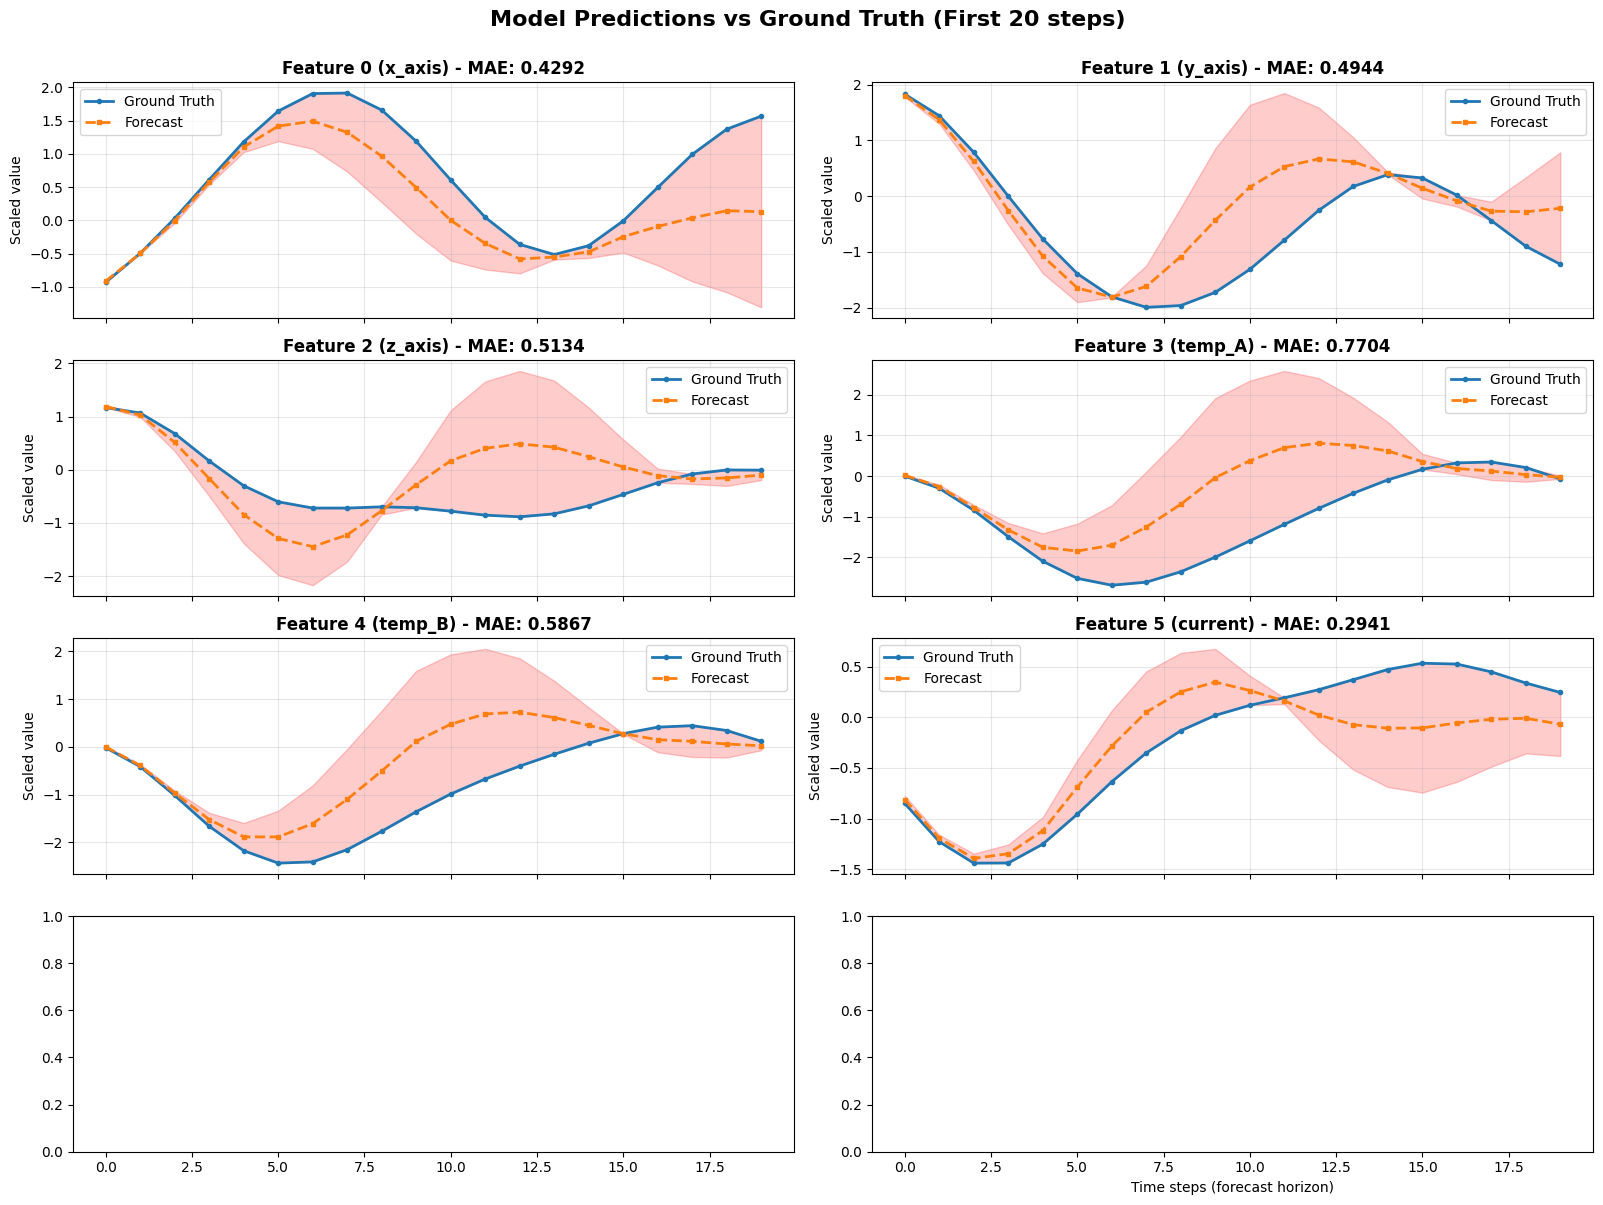

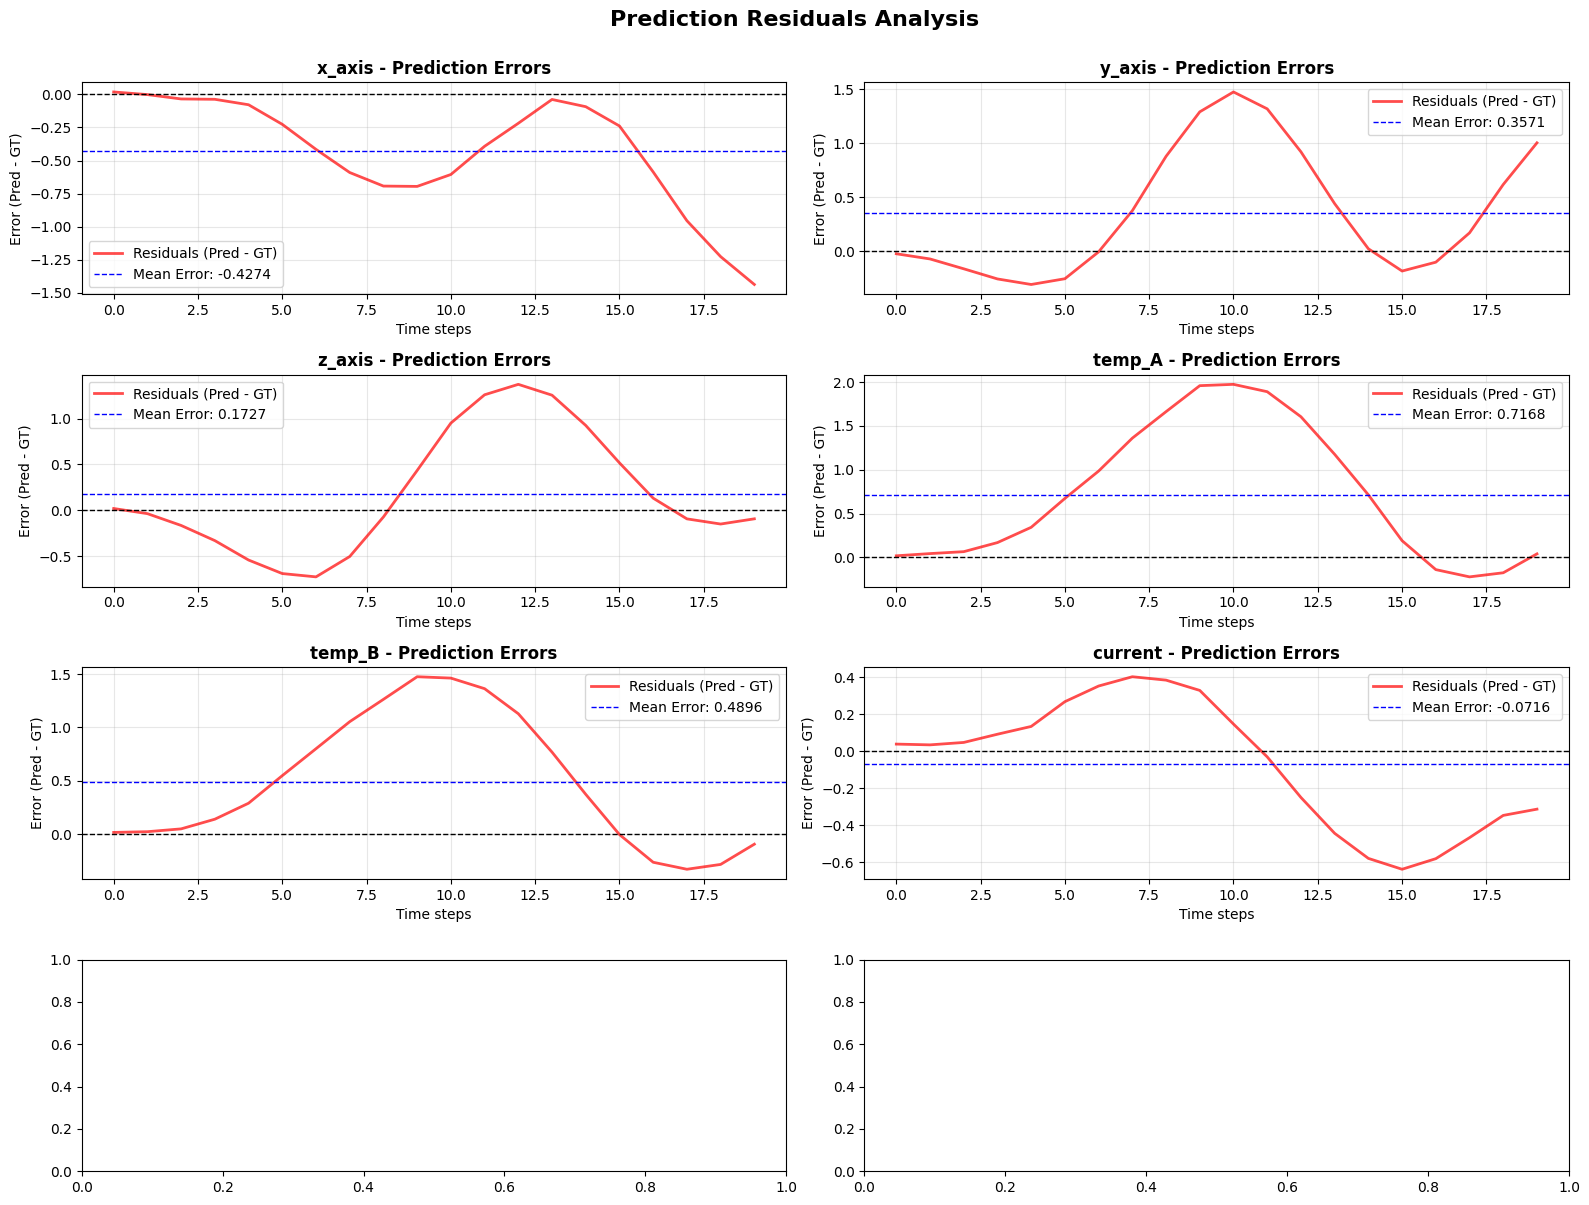


✅ Model evaluation and visualization complete!


In [ ]:
# Evaluate
test_metrics = trainer.evaluate(test_ds)
print("Test metrics:", test_metrics)

# Forecast on the last test window
last_past = torch.from_numpy(X_test_np[-100:-99]).to(device)  # (1, L, C)
with torch.no_grad():
    out = model(past_values=last_past)

# ✅ FIX: Handle tuple output
preds = out.prediction_outputs
if isinstance(preds, tuple):
    preds = preds[0]  # Extract predictions tensor from tuple

pred = preds.squeeze(0).cpu().numpy()          # (T, C)
gt   = y_test_np[-100]                                     # (T, C)

# ✅ STEP 5: Print prediction results (First 500 timesteps or all if less)
print("\n" + "="*80)
print("STEP 5: MODEL PREDICTIONS")
print("="*80)
print(f"\nPrediction shape: {pred.shape}")
print(f"Ground truth shape: {gt.shape}")

# Print predictions and ground truth
timesteps_to_show = min(500, prediction_length)
print(f"\nPredictions (First {timesteps_to_show} timesteps):")
df_pred = pd.DataFrame(pred[:timesteps_to_show], columns=feature_cols)
df_pred.index.name = 'Timestep'
print(df_pred)

print(f"\nGround Truth (First {timesteps_to_show} timesteps):")
df_gt = pd.DataFrame(gt[:timesteps_to_show], columns=feature_cols)
df_gt.index.name = 'Timestep'
print(df_gt)

# Calculate per-feature metrics
print(f"\nPer-Feature Metrics (First {timesteps_to_show} timesteps):")
metrics_list = []
for i, col in enumerate(feature_cols):
    mae = np.mean(np.abs(pred[:timesteps_to_show, i] - gt[:timesteps_to_show, i]))
    rmse = np.sqrt(np.mean((pred[:timesteps_to_show, i] - gt[:timesteps_to_show, i])**2))
    mape = np.mean(np.abs((gt[:timesteps_to_show, i] - pred[:timesteps_to_show, i]) /
                          (np.abs(gt[:timesteps_to_show, i]) + 1e-8))) * 100

    # Check if predictions are flat
    pred_std = np.std(pred[:timesteps_to_show, i])
    gt_std = np.std(gt[:timesteps_to_show, i])

    metrics_list.append({
        'Feature': col,
        'MAE': f'{mae:.6f}',
        'RMSE': f'{rmse:.6f}',
        'MAPE': f'{mape:.2f}%',
        'Pred_Std': f'{pred_std:.6f}',
        'GT_Std': f'{gt_std:.6f}',
        'Flatness_Ratio': f'{pred_std/gt_std:.4f}' if gt_std > 0 else 'N/A'
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df.to_string(index=False))

# Warning if predictions are too flat
print("\n⚠️ FLATNESS CHECK:")
for i, col in enumerate(feature_cols):
    pred_range = pred[:, i].max() - pred[:, i].min()
    gt_range = gt[:, i].max() - gt[:, i].min()
    flatness_ratio = pred_range / gt_range if gt_range > 0 else 0

    if flatness_ratio < 0.3:
        print(f"🚨 WARNING: {col} predictions are TOO FLAT!")
        print(f"   Prediction range: {pred_range:.6f}, Ground truth range: {gt_range:.6f}")
        print(f"   Flatness ratio: {flatness_ratio:.4f} (should be > 0.5 for good predictions)")
    else:
        print(f"✅ {col}: Flatness ratio = {flatness_ratio:.4f} (OK)")

# Plot first 100 forecast points vs ground truth per feature
steps_to_plot = min(100, prediction_length)
fig, axes = plt.subplots(4, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    ax.plot(gt[:steps_to_plot, i], label="Ground Truth", linewidth=2, marker='o', markersize=3)
    ax.plot(pred[:steps_to_plot, i], label="Forecast", linewidth=2, linestyle="--", marker='s', markersize=3)

    # Add shaded error region
    ax.fill_between(range(steps_to_plot),
                     pred[:steps_to_plot, i] - np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
                     pred[:steps_to_plot, i] + np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
                     alpha=0.2, color='red')

    # Calculate metrics for this window
    mae = np.mean(np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]))

    ax.set_title(f"Feature {i} ({feature_cols[i]}) - MAE: {mae:.4f}", fontweight='bold')
    ax.set_ylabel("Scaled value")
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Time steps (forecast horizon)")
plt.suptitle(f'Model Predictions vs Ground Truth (First {steps_to_plot} steps)',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ✅ ADDITIONAL VISUALIZATION: Residuals (Errors)
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    residuals = pred[:steps_to_plot, i] - gt[:steps_to_plot, i]

    ax.plot(residuals, label="Residuals (Pred - GT)", linewidth=2, color='red', alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=np.mean(residuals), color='blue', linestyle='--', linewidth=1,
               label=f'Mean Error: {np.mean(residuals):.4f}')

    ax.set_title(f"{feature_cols[i]} - Prediction Errors", fontweight='bold')
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Error (Pred - GT)")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle('Prediction Residuals Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Model evaluation and visualization complete!")

In [ ]:
# Add this after training to check what model learned:
print("\n🔍 PREDICTION VARIANCE CHECK:")
for i in range(num_features):
    pred_var = np.var(pred[:, i])
    gt_var = np.var(gt[:, i])
    print(f"{feature_cols[i]}: Pred_Var={pred_var:.6f}, GT_Var={gt_var:.6f}, Ratio={pred_var/gt_var:.4f}")


🔍 PREDICTION VARIANCE CHECK:
x_axis: Pred_Var=0.059608, GT_Var=1.398251, Ratio=0.0426
y_axis: Pred_Var=0.016474, GT_Var=1.868500, Ratio=0.0088
z_axis: Pred_Var=0.025645, GT_Var=3.319834, Ratio=0.0077
temp_A: Pred_Var=0.215123, GT_Var=0.805926, Ratio=0.2669
temp_B: Pred_Var=0.380475, GT_Var=0.915201, Ratio=0.4157
current: Pred_Var=0.513694, GT_Var=1.301082, Ratio=0.3948


In [ ]:
# Save model and scaler
# save_dir = "./artifacts/patchtst_sensor_multivar/"
save_dir = os.path.join(model_paths, "artifacts/patchtst_sensor_multivar/")
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)

import pickle
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Optional: ONNX export for deployment
# !pip install onnx onnxscript
# import torch.onnx
# dummy = torch.randn(1, context_length, num_features).to(device)
# torch.onnx.export(
#     model,
#     (dummy,),
#     os.path.join(save_dir, "patchtst_forecast.onnx"),
#     input_names=["past_values"],
#     output_names=["predictions"],
#     dynamic_axes={"past_values": {0: "batch_size"}, "predictions": {0: "batch_size"}},
#     opset_version=17
# )


In [ ]:
# best_model_dir = os.path.join(
#     model_paths, "checkpoints/patchtst_sensor"
# )

# # Force local loading
# model = PatchTSTForPrediction.from_pretrained(
#     best_model_dir,
#     local_files_only=True   # <-- important
# ).to(device)

# trainer.model = model


## **Model Inference**

### HuggingFace Transformer Inference

In [ ]:
import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import PatchTSTForPrediction
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Path to your saved model artifacts
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_sensor_multivar/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load trained PatchTST model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchTSTForPrediction.from_pretrained(model_paths).to(device)

# Load scaler
with open(os.path.join(model_paths, "scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)


In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/1-RAW_HOURLY_DATA/minutely_sensor_dataset.csv"
df = pd.read_csv(csv_path)

# Select the same 8 features
feature_cols = df.columns[:8].tolist()
data = df[feature_cols].values.astype(np.float32)

# Scale using the loaded scaler
data_scaled = scaler.transform(data).astype(np.float32)

# Define context/prediction lengths (must match training)
context_length = 160
prediction_length = 20
num_features = data_scaled.shape[1]


In [ ]:
def build_windows(arr, context_len, pred_len):
    X_list, Y_list = [], []
    T = arr.shape[0]
    for start in range(0, T - context_len - pred_len + 1):
        end_ctx = start + context_len
        end_pred = end_ctx + pred_len
        X_list.append(arr[start:end_ctx])
        Y_list.append(arr[end_ctx:end_pred])
    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)
    return X.astype(np.float32), Y.astype(np.float32)

X_test_np, y_test_np = build_windows(data_scaled, context_length, prediction_length)


In [ ]:
# Forecast on the last test window
last_past = torch.from_numpy(X_test_np[-100:-99]).to(device)  # (1, L, C)
with torch.no_grad():
    out = model(past_values=last_past)

pred = out.prediction_outputs.squeeze(0).cpu().numpy()   # (T, C)
gt   = y_test_np[-100]                                     # (T, C)


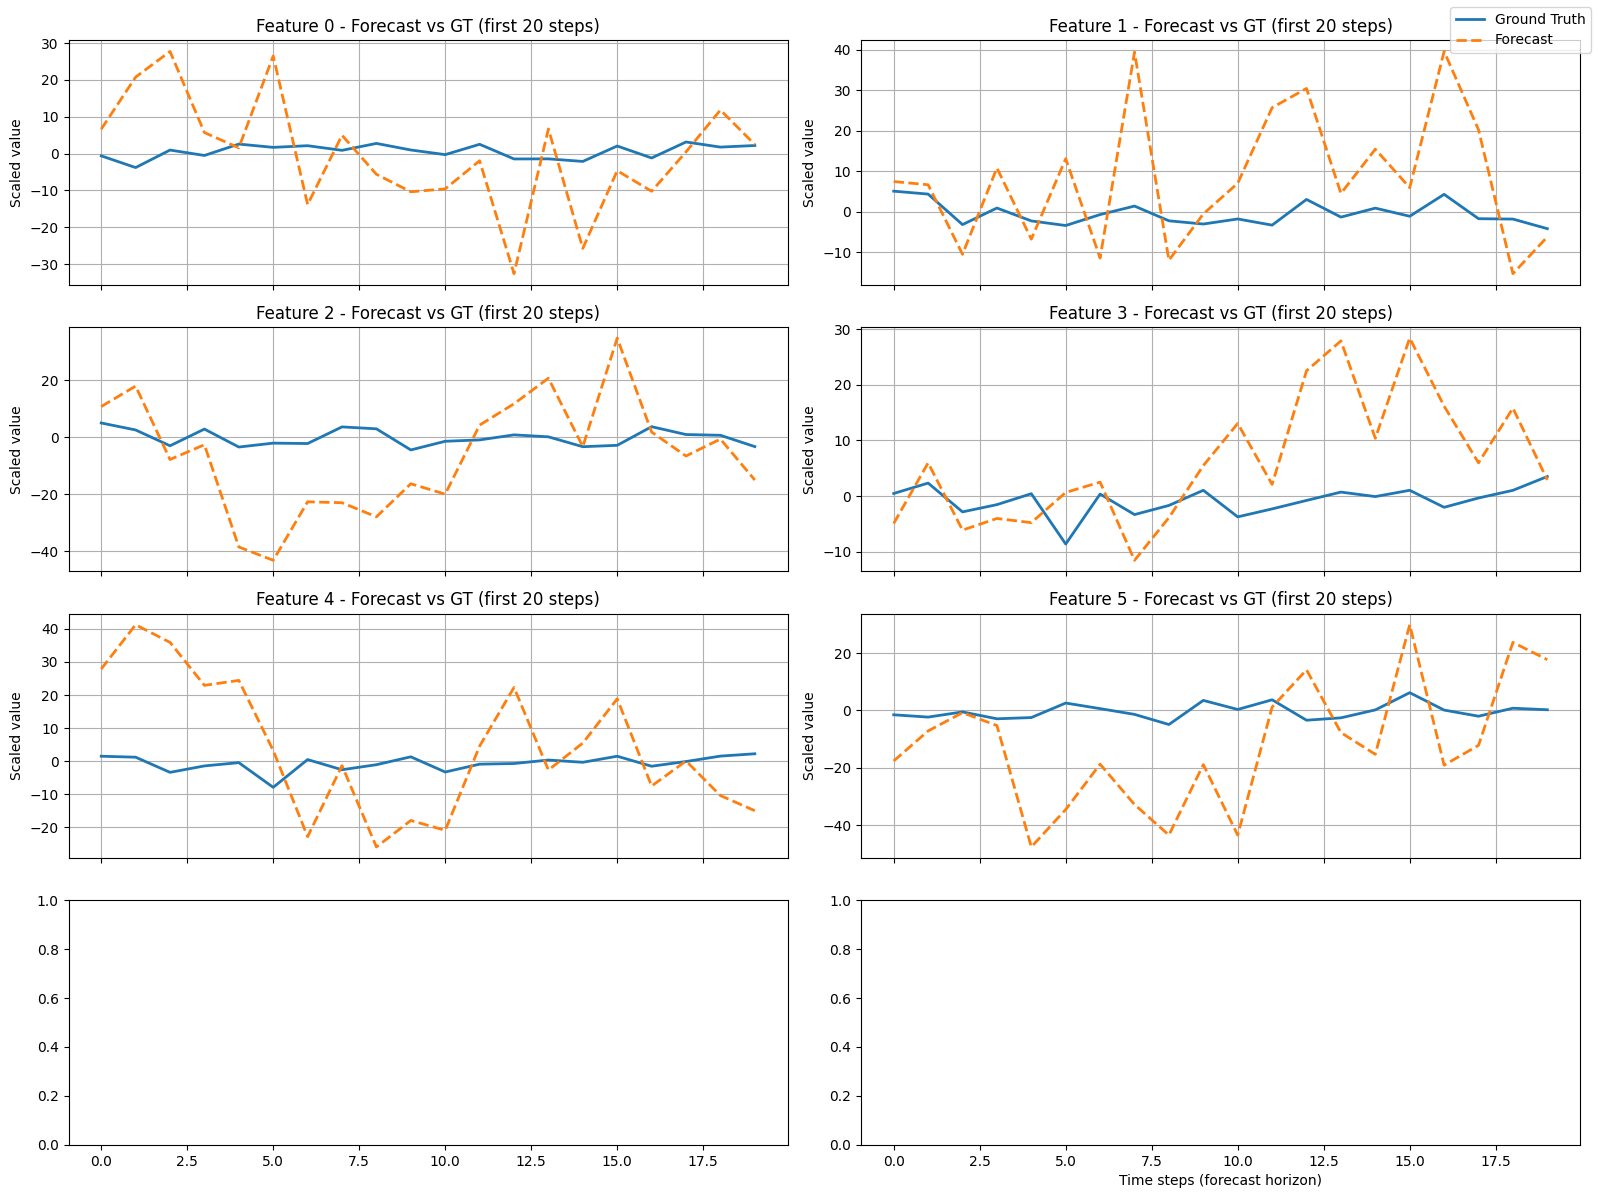

In [ ]:
steps_to_plot = min(100, prediction_length)
fig, axes = plt.subplots(4, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    ax.plot(gt[:steps_to_plot, i], label="Ground Truth", linewidth=2)
    ax.plot(pred[:steps_to_plot, i], label="Forecast", linewidth=2, linestyle="--")
    ax.set_title(f"Feature {i} - Forecast vs GT (first {steps_to_plot} steps)")
    ax.set_ylabel("Scaled value")
    ax.grid(True)

axes[-1].set_xlabel("Time steps (forecast horizon)")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()


### Pytorch Transformer Inference

In [12]:
# ==============================================
# LOAD HUGGINGFACE MODEL & SAVE AS .pt FILE
# ==============================================

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import pickle
from transformers import PatchTSTForPrediction

# Define paths
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/"
hf_model_dir = os.path.join(model_paths, "artifacts/patchtst_sensor_multivar/")
save_dir = os.path.join(model_paths, "artifacts/")
os.makedirs(save_dir, exist_ok=True)

print("="*80)
print("CONVERTING HUGGINGFACE MODEL TO .pt FILE")
print("="*80)

# Step 1: Load the HuggingFace model
print(f"\n1️⃣ Loading HuggingFace model from: {hf_model_dir}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    model = PatchTSTForPrediction.from_pretrained(
        hf_model_dir,
        local_files_only=True
    )
    print("✅ Model loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# Step 2: Load scaler (if it exists)
scaler_path = os.path.join(hf_model_dir, "scaler.pkl")
scaler = None
if os.path.exists(scaler_path):
    print(f"\n2️⃣ Loading scaler from: {scaler_path}")
    with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)
    print("✅ Scaler loaded successfully")
else:
    print(f"\n⚠️  Scaler not found at: {scaler_path}")
    print("   Model will be saved without scaler")

# Step 3: Move model to CPU and set to eval mode
print("\n3️⃣ Preparing model for saving...")
model = model.cpu()
model.eval()
print("✅ Model ready for saving")

# Step 4: Save FULL model as .pt file
full_model_path = os.path.join(save_dir, "patchtst_full_model.pt")
print(f"\n4️⃣ Saving full model to: {full_model_path}")
torch.save(model, full_model_path)
print("✅ Full model saved as .pt")

# Step 5: Save scaler separately (if it exists)
if scaler is not None:
    scaler_save_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_save_path, "wb") as f:
        pickle.dump(scaler, f)
    print(f"✅ Scaler saved to: {scaler_save_path}")

# Step 6: Verify file size
file_size_mb = os.path.getsize(full_model_path) / (1024 * 1024)
print(f"\n📊 File Info:")
print(f"   Path: {full_model_path}")
print(f"   Size: {file_size_mb:.2f} MB")
print(f"   Format: Full PyTorch model (.pt)")
print(f"   Contains: Model architecture + weights + config")

print("\n" + "="*80)
print("✅ CONVERSION COMPLETE!")
print("="*80)
print(f"\n📁 Saved files:")
print(f"   1. Model: {full_model_path}")
if scaler is not None:
    print(f"   2. Scaler: {scaler_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CONVERTING HUGGINGFACE MODEL TO .pt FILE

1️⃣ Loading HuggingFace model from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_sensor_multivar/
✅ Model loaded successfully

2️⃣ Loading scaler from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_sensor_multivar/scaler.pkl
✅ Scaler loaded successfully

3️⃣ Preparing model for saving...
✅ Model ready for saving

4️⃣ Saving full model to: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_full_model.pt
✅ Full model saved as .pt
✅ Scaler saved to: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/scaler.pkl

📊 File Info:
   Path: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_full_model.pt
   Size: 49.83 MB
   Format: Full PyTorch model (.pt)
  

In [13]:
# ==============================================
# LOAD MODEL FROM .pt FILE
# ==============================================

from google.colab import drive
drive.mount('/content/drive')

import torch
import pickle
import os

# Path to saved model
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/"
model_path = os.path.join(model_paths, "artifacts/patchtst_full_model.pt")
scaler_path = os.path.join(model_paths, "artifacts/scaler.pkl")

print("="*80)
print("LOADING MODEL FROM .pt FILE")
print("="*80)

# Step 1: Load model
print(f"\n1️⃣ Loading model from: {model_path}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    # Load with weights_only=False for PyTorch 2.6+
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# Step 2: Load scaler (if needed)
if os.path.exists(scaler_path):
    print(f"\n2️⃣ Loading scaler from: {scaler_path}")
    with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)
    print("✅ Scaler loaded successfully!")
else:
    print(f"\n⚠️  Scaler not found at: {scaler_path}")
    scaler = None

# Step 3: Model info
print(f"\n📊 Model Info:")
print(f"   Device: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Step 4: Test inference
print(f"\n🧪 Testing inference...")
import numpy as np
dummy_input = torch.randn(1, 160, 6).to(device)  # Adjust shape as needed

with torch.no_grad():
    output = model(past_values=dummy_input)
    preds = output.prediction_outputs
    if isinstance(preds, tuple):
        preds = preds[0]
    print(f"   Input shape: {dummy_input.shape}")
    print(f"   Output shape: {preds.shape}")

print("\n" + "="*80)
print("✅ MODEL READY FOR INFERENCE!")
print("="*80)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOADING MODEL FROM .pt FILE

1️⃣ Loading model from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_full_model.pt
✅ Model loaded successfully!

2️⃣ Loading scaler from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/scaler.pkl
✅ Scaler loaded successfully!

📊 Model Info:
   Device: cpu
   Parameters: 13,031,956

🧪 Testing inference...
   Input shape: torch.Size([1, 160, 6])
   Output shape: torch.Size([1, 20, 6])

✅ MODEL READY FOR INFERENCE!


# Next